### CIFAR-10 데이터를 이용해 MLP(Multi Layer Perceptron) 설계하기

In [23]:
''' 1. Import Module '''
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [24]:
''' 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인 '''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print("Using PyTorch version: ", torch.__version__, " Device: ", DEVICE)

Using PyTorch version:  2.0.1+cu118  Device:  cuda


In [25]:
BATCH_SIZE = 32
EPOCHS = 10

In [26]:
''' 3. CIFAR-10 데이터 다운로드(Train set, Test set 분리하기) '''
train_dataset = datasets.CIFAR10(root = "/content/data/CIFAR_10",
                                 train = True,
                                 download = True,
                                 transform = transforms.ToTensor())
test_dataset = datasets.CIFAR10(root = "/content/data/CIFAR_10",
                                train = False,
                                transform = transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

Files already downloaded and verified


In [27]:
''' 4. 데이터 확인하기 (1) '''
for (x_train, y_train) in train_loader:
    print("x_train: ", x_train.size(), " type: ", x_train.type())
    print("y_train: ", y_train.size(), " type: ", y_train.type())
    break

x_train:  torch.Size([32, 3, 32, 32])  type:  torch.FloatTensor
y_train:  torch.Size([32])  type:  torch.LongTensor


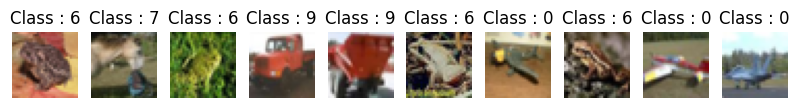

In [28]:
''' 5. 데이터 확인하기 (2) '''
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(x_train[i],(1,2,0)))
    plt.title("Class : " + str(y_train[i].item()))

In [29]:
''' 6. Multi Layer Perceptron(MLP) 모델 설계하기 '''
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)
        return x

In [30]:
''' 7. Optimizer, Object Function 설정하기 '''
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [39]:
''' 8. MLP 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f})]\tTrain Loss: {:.6f}".format(
                Epoch, batch_idx % len(image),
                len(train_loader.dataset), 100 * batch_idx / len(train_loader),
                loss.item()
            ))

In [32]:
''' 9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [40]:
''' 10. MLP 학습을 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인하기 '''
for Epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval=200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print('\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f}% \n'.format(Epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000 (0)]	Train Loss: 2.281750
Train Epoch: 1 [8/50000 (13)]	Train Loss: 2.165592
Train Epoch: 1 [16/50000 (26)]	Train Loss: 2.000461
Train Epoch: 1 [24/50000 (38)]	Train Loss: 1.547254
Train Epoch: 1 [0/50000 (51)]	Train Loss: 1.878031
Train Epoch: 1 [8/50000 (64)]	Train Loss: 1.956931
Train Epoch: 1 [16/50000 (77)]	Train Loss: 1.500775
Train Epoch: 1 [24/50000 (90)]	Train Loss: 1.642485

[EPOCH: 1], 	Test Loss: 0.0525, 	Test Accuracy: 39.55% 

Train Epoch: 2 [0/50000 (0)]	Train Loss: 1.559711
Train Epoch: 2 [8/50000 (13)]	Train Loss: 1.781450
Train Epoch: 2 [16/50000 (26)]	Train Loss: 1.931235
Train Epoch: 2 [24/50000 (38)]	Train Loss: 1.408938
Train Epoch: 2 [0/50000 (51)]	Train Loss: 1.568932
Train Epoch: 2 [8/50000 (64)]	Train Loss: 1.534693
Train Epoch: 2 [16/50000 (77)]	Train Loss: 1.559818
Train Epoch: 2 [24/50000 (90)]	Train Loss: 1.850648

[EPOCH: 2], 	Test Loss: 0.0495, 	Test Accuracy: 43.94% 

Train Epoch: 3 [0/50000 (0)]	Train Loss: 1.680410
Train Epoch: